In [70]:
#Importing libraries

import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2
from PIL import Image
import geopandas as gpd
import geodatasets
from shapely.geometry import Point

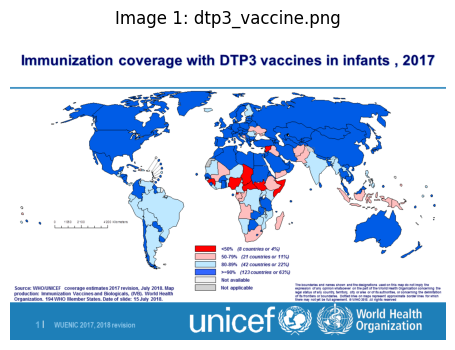

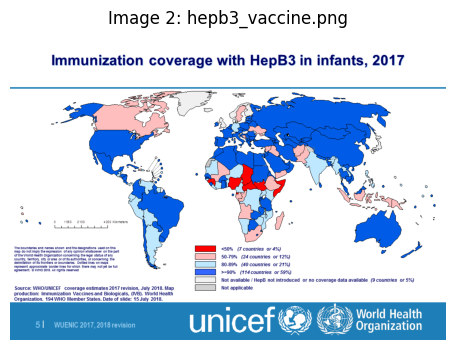

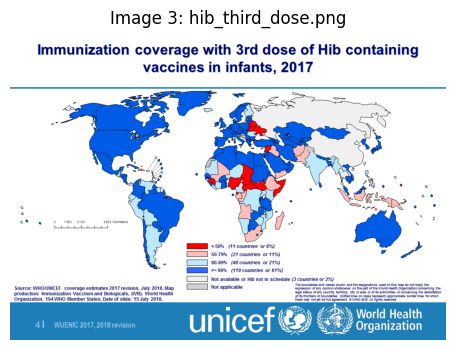

In [71]:
# Displaying the first 3 images

# Path to raw images
raw_image_path = '../data/raw_maps/'

# Listing all image files
image_files = [f for f in os.listdir(raw_image_path) if f.endswith(('.png'))]

# Displaying the first 3 images
for i, file_name in enumerate(image_files[:3]):
    img_path = os.path.join(raw_image_path, file_name)
    img = Image.open(img_path)

    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(f'Image {i+1}: {file_name}')
    plt.axis('off')
    plt.show()


In [72]:
# Loading admin-0 countries
shapefile_path = "../data/shapefiles/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

print(world.columns.tolist())
print(world.head())

['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_KO', 'ADM0_A3_VN', 'ADM0_A3_TR', 'AD


Processing High demand areas...
  Extracted 2 High-demand country segments.


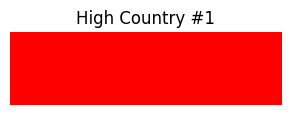

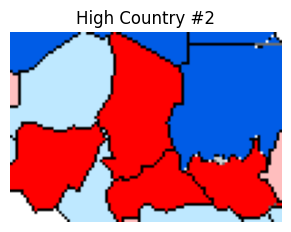


Processing Medium demand areas...
  Extracted 0 Medium-demand country segments.

Processing Low demand areas...
  Extracted 8 Low-demand country segments.


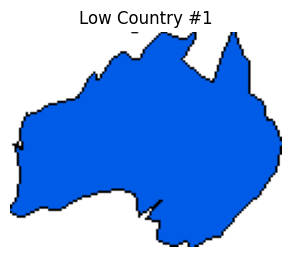

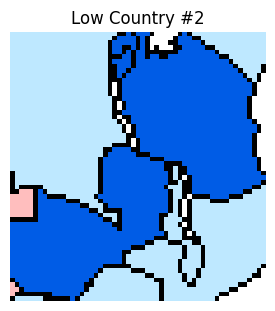

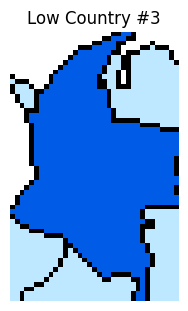

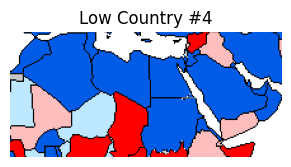

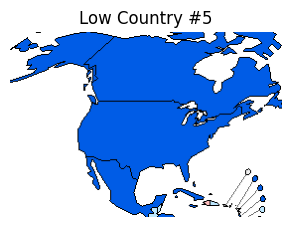

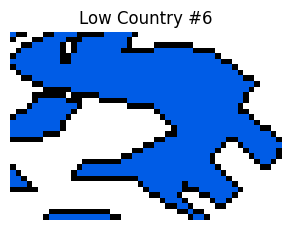

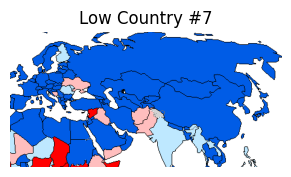

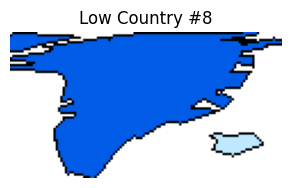

In [73]:
# Loading image for test data (DTP3 map)
img_path = "../data/raw_maps/dtp3_vaccine.png"
image = cv2.imread(img_path)

# Base output folder for train data
base_output_folder = "../data/test"

# Defining color ranges for demand levels
demand_levels = {
    "High": {
        "lower": np.array([0, 0, 200], dtype="uint8"),   # Red
        "upper": np.array([50, 50, 255], dtype="uint8")
    },
    "Medium": {
        "lower": np.array([200, 0, 200], dtype="uint8"), # Pink
        "upper": np.array([255, 100, 255], dtype="uint8")
    },
    "Low": {
        "lower": np.array([200, 0, 0], dtype="uint8"),   # Blue
        "upper": np.array([255, 100, 100], dtype="uint8")
    }
}

for demand, bounds in demand_levels.items():
    print(f"\nProcessing {demand} demand areas...")

    # Create a specific subfolder for this demand level
    output_folder = os.path.join(base_output_folder, f"{demand.lower()}_demand")
    os.makedirs(output_folder, exist_ok=True)

    # Creating mask for the current demand color
    mask = cv2.inRange(image, bounds["lower"], bounds["upper"])

    # Finding contours for regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    country_segments = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500:  # Filter small areas
            x, y, w, h = cv2.boundingRect(cnt)
            roi = image[y:y+h, x:x+w]
            country_segments.append(roi)

    print(f"  Extracted {len(country_segments)} {demand}-demand country segments.")

    # Showing and saving each segment
    for i, roi in enumerate(country_segments):
        plt.figure(figsize=(3.5, 3.5))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"{demand} Country #{i+1}")
        plt.axis("off")
        plt.show()

        file_name = f"{demand.lower()}_demand_country_{i+1}.png"
        cv2.imwrite(os.path.join(output_folder, file_name), roi)


Processing High demand areas in Pol3 image...
  Extracted 4 High-demand country segments.


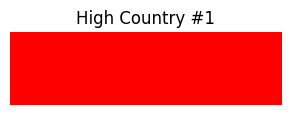

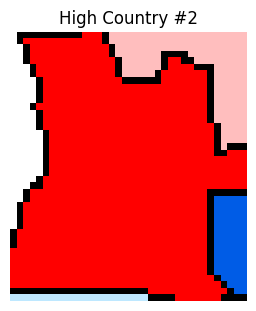

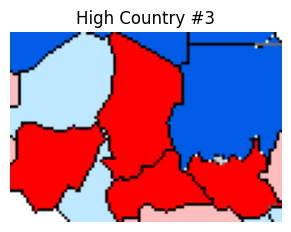

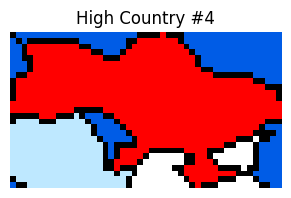


Processing Medium demand areas in Pol3 image...
  Extracted 0 Medium-demand country segments.

Processing Low demand areas in Pol3 image...
  Extracted 8 Low-demand country segments.


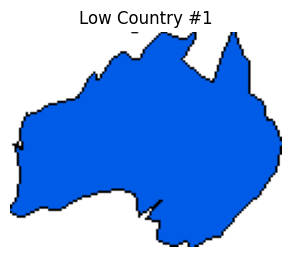

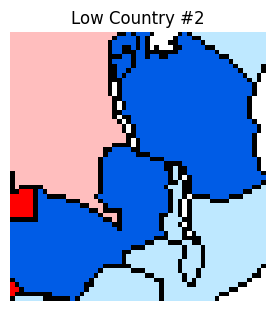

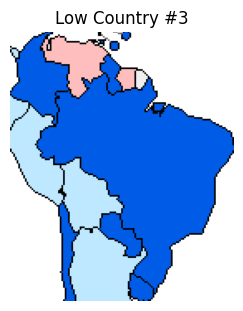

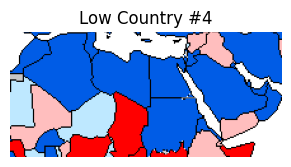

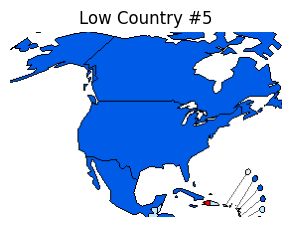

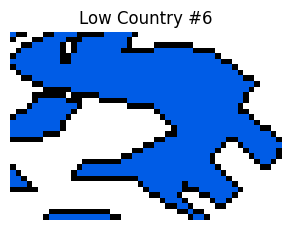

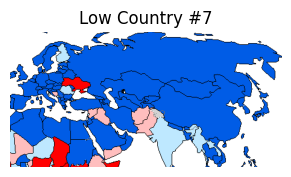

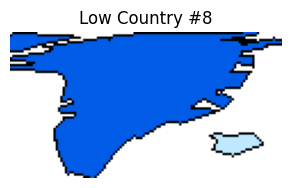

In [74]:
# Loading image for test data (Pol3 map)
img_path = "../data/raw_maps/polio_third_dose.png"
image = cv2.imread(img_path)

# Base output folder (train data)
base_output_folder = "../data/train"

# Defining color ranges for demand levels (adjust if Pol3 colors are different!)
demand_levels = {
    "High": {
        "lower": np.array([0, 0, 200], dtype="uint8"),   # Red
        "upper": np.array([50, 50, 255], dtype="uint8")
    },
    "Medium": {
        "lower": np.array([200, 0, 200], dtype="uint8"), # Pink
        "upper": np.array([255, 100, 255], dtype="uint8")
    },
    "Low": {
        "lower": np.array([200, 0, 0], dtype="uint8"),   # Blue
        "upper": np.array([255, 100, 100], dtype="uint8")
    }
}

for demand, bounds in demand_levels.items():
    print(f"\nProcessing {demand} demand areas in Pol3 image...")

    # Create a specific output folder for this demand level
    output_folder = os.path.join(base_output_folder, f"{demand.lower()}_demand")
    os.makedirs(output_folder, exist_ok=True)

    # Create mask for current demand level
    mask = cv2.inRange(image, bounds["lower"], bounds["upper"])

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    country_segments = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500:  # Filter noise
            x, y, w, h = cv2.boundingRect(cnt)
            roi = image[y:y+h, x:x+w]
            country_segments.append(roi)

    print(f"  Extracted {len(country_segments)} {demand}-demand country segments.")

    # Show and save
    for i, roi in enumerate(country_segments):
        plt.figure(figsize=(3.5, 3.5))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"{demand} Country #{i+1}")
        plt.axis("off")
        plt.show()

        file_name = f"{demand.lower()}_demand_country_{i+1}.png"
        cv2.imwrite(os.path.join(output_folder, file_name), roi)

**Vaccine CNN Model**

In [78]:
# Preprocessing image data

# Parameters
image_size = (64, 64)
dataset_path = "../data/train"
categories = os.listdir(dataset_path)

# Loading and preprocessing images
X, y = [], []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0
        X.append(img_array)
        y.append(category)    

# Reshaping images
X_train = np.array(X_train).reshape(len(X_train), *image_size, 3)
X_test = np.array(X_test).reshape(len(X_test), *image_size, 3)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {X_test.shape}")

X_train shape: (10, 64, 64, 3)
y_train shape: (10, 64, 64, 3)
X_test shape: (3, 64, 64, 3)
y_test shape: (3, 64, 64, 3)


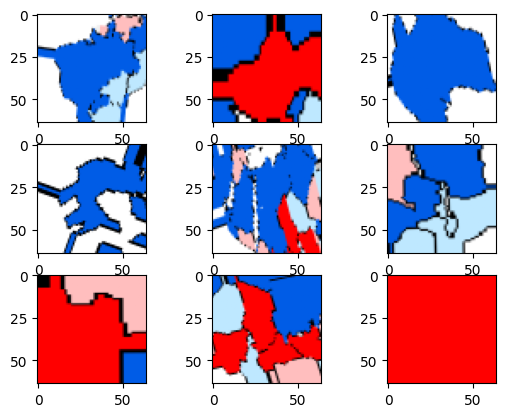

In [75]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

# Showing augemented images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_batch[i])
    plt.show()
    break

In [82]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Convert string labels to integers
le = LabelEncoder()
y_categorical = y

# One-hot encode the integer labels
y_categorical = to_categorical(y_encoded, num_classes=3)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.05),
    Dense(3, activation='softmax')  # 3-class output
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

c:\Users\Nicolle School\ml_pipeline_summative\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7143 - loss: 0.9289 - val_accuracy: 0.5000 - val_loss: 0.9147
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7143 - loss: 0.8231 - val_accuracy: 1.0000 - val_loss: 0.3651
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.1776 - val_accuracy: 1.0000 - val_loss: 0.2381
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.1076 - val_accuracy: 1.0000 - val_loss: 0.2246
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.2729
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0337 - val_accuracy: 1.0000 - val_loss: 0.1995
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0937
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.

**Model testing**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


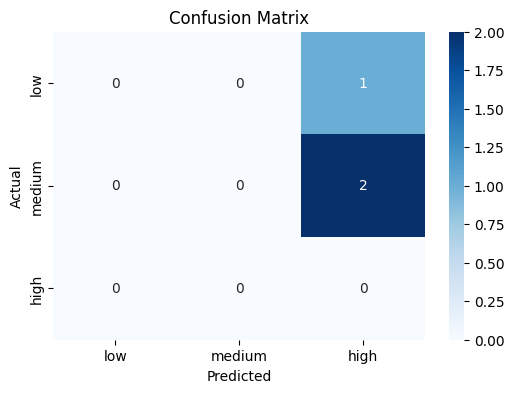

In [90]:
import seaborn as sns

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ['low', 'medium', 'high']

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [88]:
# Saving the model
model.save('../models/vaccine_demand_model.h5')

**Model retraining**

In [89]:
# Retraining the model
def retrain_model_if_needed(X_train, y_train, X_test, y_test, accuracy_threshold=0.85):
    model = load_model("../models/vaccine_demand_model.h5")
    loss, accuracy = model.evaluate(X_test, y_test)
    
    if accuracy < accuracy_threshold:
        print("Accuracy dropped. Retraining...")
        model.fit(X_train, y_train, epochs=5, validation_split=0.2)
        model.save("../models/vaccine_demand_model.h5")
    else:
        print("Model is performing well. No need to retrain.")

    return model